In [61]:
import os
os.chdir('/workspace')
print("当前工作目录:", os.getcwd())
import re
import matplotlib.pyplot as plt
import numpy as np

当前工作目录: /workspace


In [62]:
path = '/workspace/FourCastNet/results/era5_wind/precip/'
file_name = os.path.join(path,'gpu16-2.info')
gpuid = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# gpuid = [0,1]

In [63]:
def parse_ixsmi_output(output):
    gpu_infos = {}
    lines = output.splitlines()
    current_gpu_id = None
    
    for line in lines:
        gpu_id_match = re.match(r'^\| (\d+)\s+', line)
        if gpu_id_match:
            current_gpu_id = int(gpu_id_match.group(1))
            gpu_infos[current_gpu_id] = {'memory_usage': 0, 'power_usage': None}
        
        if current_gpu_id is not None:
            memory_match = re.search(r'(\d+)MiB / \d+MiB', line)
            if memory_match:
                memory_usage = int(memory_match.group(1)) / 1024  # 转换为 GB
                gpu_infos[current_gpu_id]['memory_usage'] = memory_usage
            
            power_match = re.search(r'(\d+)W / \d+W', line)
            if power_match and "N/A" not in line:
                power_usage = int(power_match.group(1))
                gpu_infos[current_gpu_id]['power_usage'] = power_usage
                
            gpu_ulti_match = re.search(r'\d+%.*?(\d+)%', line)
            if gpu_ulti_match:
                gpu_util = int(gpu_ulti_match.group(1))
                gpu_infos[current_gpu_id]['gpu_util'] = gpu_util                
    
    return gpu_infos

def parse_log(file_name):
    with open(file_name, 'r') as file:
        data = file.read()

    timestamps = re.findall(r'Timestamp\s+(.*?)\n', data)
    timestamp_blocks = data.split('Timestamp')[1:]

    steps = []
    for block in timestamp_blocks:
        gpu_infos = parse_ixsmi_output(block)
        steps.append(gpu_infos)

    return timestamps, steps

timestamps, steps = parse_log(file_name)

In [64]:
def calculate_statistics(steps,gpu_id=None):
    usages = []

    for step in steps:
        power_usage = [gpu['power_usage'] for id, gpu in step.items()
                        if id in gpu_id and
                        gpu['memory_usage'] > 0.2 and 
                        gpu['power_usage'] is not None]
        
        memory_usage = [gpu['memory_usage'] for id, gpu in step.items() 
                        if id in gpu_id and
                        gpu['memory_usage'] > 0.2]
        
        gpu_util = [gpu['gpu_util'] for id, gpu in step.items() 
                if id in gpu_id and
                gpu['memory_usage'] > 0.2 and 
                gpu['gpu_util'] is not None]
        # print(power_usage)
        # print(memory_usage)
        # print(gpu_util)
        if memory_usage:
            usages.append((np.mean(power_usage) if power_usage else 0, 
                           np.mean(memory_usage) if memory_usage else 0, 
                           np.max(memory_usage) if memory_usage else 0,
                           np.mean(gpu_util) if gpu_util else 0 
                           ))
    return usages

usages = calculate_statistics(steps,gpu_id=gpuid)


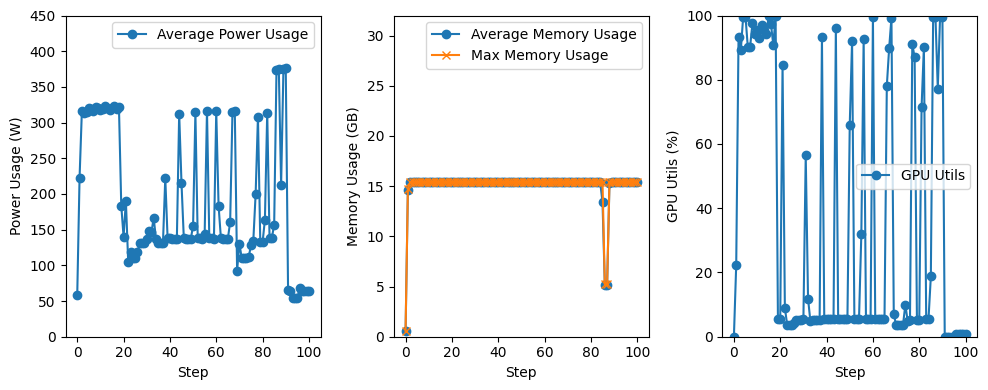

(15.003333365563119, 186.4621640735502, 36.96782178217822)

In [65]:
step_start = 0 #cdj
step_end = -1 #cdj
usages = usages[step_start:step_end]

def plot_statistics(usages):
    steps = range(len(usages))
    avg_power = [x[0] for x in usages]
    avg_memory = [x[1] for x in usages]
    max_memory = [x[2] for x in usages]
    gpu_utils = [x[3] for x in usages]

    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(steps, avg_power, marker='o', label='Average Power Usage')
    plt.ylim([0,450])
    plt.xlabel('Step')
    plt.ylabel('Power Usage (W)')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(steps, avg_memory, marker='o', label='Average Memory Usage')
    plt.plot(steps, max_memory, marker='x', label='Max Memory Usage')
    plt.ylim([0,32])
    plt.xlabel('Step')
    plt.ylabel('Memory Usage (GB)')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(steps, gpu_utils, marker='o', label='GPU Utils')
    plt.ylim([0,100])
    plt.xlabel('Step')
    plt.ylabel('GPU Utils (%)')
    plt.legend()
        
    plt.tight_layout()
    plt.show()



def overall_statistics(usages):
    all_power = [x[0] for x in usages]
    all_memory = [x[1] for x in usages]
    all_max_memory = [x[2] for x in usages]
    gpu_util = [x[3] for x in usages]

    avg_power = np.mean(all_power)
    avg_memory = np.mean(all_memory)
    max_memory = np.max(all_max_memory)
    gpu_utils = np.mean(gpu_util)

    return avg_power, avg_memory, max_memory, gpu_utils


plot_statistics(usages)
avg_power, avg_memory, max_memory, gpu_utils = overall_statistics(usages)

avg_memory, avg_power,gpu_utils
